<a href="https://colab.research.google.com/github/Bertha-ding/20MA573-yuning-ding/blob/master/USE%20SGD-LR%20model%20to%20predict%20stock%20price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install quandl

In [7]:
import quandl
def get_stock_price(start_date, end_date, stock="EOD/MSFT"):
    raw_data = quandl.get(stock, start_date=start_date, end_date=end_date, authtoken="e1wsL3tFnRAj7MwA5qH2")
    return raw_data

In [15]:
raw_training = get_stock_price("1987-03-13", "2017-12-31")

In [16]:
raw_training.shape

(1090, 12)

In [17]:
raw_training.isnull().any().any()

False

In [18]:
raw_training.describe().round(2)

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,1090.00,1090.00,1090.00,1090.00,1.090000e+03,1090.00,1090.0,1090.00,1090.00,1090.00,1090.00,1.090000e+03
mean,52.58,53.00,52.18,52.62,3.185689e+07,0.01,1.0,48.20,48.58,47.83,48.23,3.185689e+07
std,12.83,12.87,12.78,12.83,1.709372e+07,0.04,0.0,13.33,13.37,13.27,13.32,1.709372e+07
min,31.10,31.39,30.95,31.15,7.425603e+06,0.00,1.0,26.72,26.97,26.59,26.77,7.425603e+06
25%,42.96,43.26,42.61,43.06,2.185425e+07,0.00,1.0,38.18,38.65,37.81,38.34,2.185425e+07
50%,49.54,50.10,49.12,49.69,2.808245e+07,0.00,1.0,45.45,45.97,44.98,45.61,2.808245e+07
75%,60.64,61.13,60.24,60.64,3.624615e+07,0.00,1.0,56.73,57.26,56.52,56.88,3.624615e+07
max,87.12,87.50,86.23,86.85,2.025224e+08,0.42,1.0,83.59,83.96,82.74,83.33,2.025224e+08


In [29]:
# Load the test set (from 2018-01-01 to yesterday)
from datetime import date, timedelta
import pandas as pd
import pandas_market_calendars as pmc
import pandas_datareader.data as drd
import numpy as np
import seaborn as sns
from pandas_datareader import data as pdr
yesterday = (date.today()-timedelta(1)).strftime("%Y-%m-%d")
raw_test = drd.get_data_yahoo('MSFT',"2018-01-01", "2021-03-06",interval='d')

In [30]:
raw_test.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-01,237.470001,233.149994,235.899994,236.940002,25324000.0,236.940002
2021-03-02,237.300003,233.449997,237.009995,233.869995,22785500.0,233.869995
2021-03-03,233.580002,227.259995,232.160004,227.559998,33950400.0,227.559998
2021-03-04,232.490005,224.259995,226.740005,226.729996,44584200.0,226.729996
2021-03-05,233.270004,226.460007,229.520004,231.600006,41842100.0,231.600006


In [31]:
raw_training.shape

(1090, 12)

In [32]:
def generate_features(raw_data):
    df = pd.DataFrame()
    # Feature 1: Open price
    df["open"] = raw_data["Open"]
    # Feature 2: Open price on the past day
    df["open_1"] = raw_data["Open"].shift(1)
    # Feature 3: Close price on the past day
    df["close_1"] = raw_data["Close"].shift(1)
    # Feature 4: Highest price on the past day
    df["high_1"] = raw_data["High"].shift(1)
    # Feature 5: Lowest price on the past day
    df["low_1"] = raw_data["Low"].shift(1)
    # Feature 6: Volume of the past day
    df["volume_1"] = raw_data["Volume"].shift(1)
    # Feature 7: Average close price of the past five days
    df["avg_close_5"] = raw_data["Close"].rolling(5).mean().shift(1)
    # Feature 8: Average close price over the past month
    df["avg_close_30"] = raw_data["Close"].rolling(21).mean().shift(1)
    # Feature 9: Average close price over the past year
    df["avg_close_365"] = raw_data["Close"].rolling(252).mean().shift(1)
    # Feature 10: Ratio between the average price over the past week and that over the past month
    df["ratio_avg_close_5_30"] = df["avg_close_5"] / df["avg_close_30"]
    # Feature 11: Ratio between the average price over the past week and that over the past year
    df["ratio_avg_close_5_365"] = df["avg_close_5"] / df["avg_close_365"]
    # Feature 12: Ratio between the average price over the past month and that over the past year
    df["ratio_avg_close_30_365"] = df["avg_close_30"] / df["avg_close_365"]
    # Feature 13: Average volume over the past five days
    df["avg_volume_5"] = raw_data["Volume"].rolling(5).mean().shift(1)
    # Feature 14: Average volume over the past month
    df["avg_volume_30"] = raw_data["Volume"].rolling(21).mean().shift(1)
    # Feature 15: Average volume over the past year
    df["avg_volume_365"] = raw_data["Volume"].rolling(252).mean().shift(1)
    # Feature 16: Ratio between the average volume over the past week and that over the past month
    df["ratio_avg_volume_5_30"] = df["avg_volume_5"] / df["avg_volume_30"]
    # Feature 17: Ratio between the average volume over the past week and that over the past year
    df["ratio_avg_volume_5_365"] = df["avg_volume_5"] / df["avg_volume_365"]
    # Feature 18: Ratio between the average volume over the past month and that over the past year
    df["ratio_avg_volume_30_365"] = df["avg_volume_30"] / df["avg_volume_365"]
    # Feature 19: Standard deviation of the close prices over the past five days
    df["std_close_5"] = raw_data["Close"].rolling(5).std().shift(1)
    # Feature 20: Standard deviation of the close prices over the past month
    df["std_close_30"] = raw_data["Close"].rolling(21).std().shift(1)
    # Feature 21: Standard deviation of the close prices over the past year
    df["std_close_365"] = raw_data["Close"].rolling(252).std().shift(1)
    # Feature 22: Ratio between the standard deviation of the prices over the past week and that over the past month
    df["ratio_std_close_5_30"] = df["std_close_5"] / df["std_close_30"]
    # Feature 23: Ratio between the standard deviation of the prices over the past week and that over the past year
    df["ratio_std_close_5_365"] = df["std_close_5"] / df["std_close_365"]
    # Feature 24: Ratio between the standard deviation of the prices over the past month and that over the past year
    df["ratio_std_close_30_365"] = df["std_close_30"] / df["std_close_365"]
    # Feature 25: Standard deviation of the volumes over the past five days
    df["std_volume_5"] = raw_data["Volume"].rolling(5).std().shift(1)
    # Feature 26: Standard deviation of the volumes over the past month
    df["std_volume_30"] = raw_data["Volume"].rolling(21).std().shift(1)
    # Feature 27: Standard deviation of the volumes over the past year
    df["std_volume_365"] = raw_data["Volume"].rolling(252).std().shift(1)
    # Feature 28: Ratio between the standard deviation of the volumes over the past week and that over the past month
    df["std_volume_5_30"] = df["std_volume_5"] / df["std_volume_30"]
    # Feature 29: Ratio between the standard deviation of the volumes over the past week and that over the past year
    df["std_volume_5_365"] = df["std_volume_5"] / df["std_volume_365"]
    # Feature 30: Ratio between the standard deviation of the volumes over the past month and that over the past year
    df["std_volume_30_365"] = df["std_volume_30"] / df["std_volume_365"]
    # Feature 31: Daily return of the past day
    df["return_1"] = ((raw_data["Close"] - raw_data["Close"].shift(1)) / raw_data["Close"].shift(1)).shift(1)
    # Feature 32: Weekly return of the past week
    df["return_5"] = ((raw_data["Close"] - raw_data["Close"].shift(5)) / raw_data["Close"].shift(5)).shift(1)
    # Feature 33: Monthly return of the past month
    df["return_30"] = ((raw_data["Close"] - raw_data["Close"].shift(21)) / raw_data["Close"].shift(21)).shift(1)
    # Feature 34: Yearly return of the past year
    df["return_365"] = ((raw_data["Close"] - raw_data["Close"].shift(252)) / raw_data["Close"].shift(252)).shift(1)
    # Feature 35: Moving average of the daily returns over the past week
    df["moving_avg_return_5"] = df["return_1"].rolling(5).mean()
    # Feature 36: Moving average of the daily returns over the past month
    df["moving_avg_return_30"] = df["return_1"].rolling(21).mean()
    # Feature 37: Moving average of the daily returns over the past year
    df["moving_avg_return_365"] = df["return_1"].rolling(252).mean()
    # Target
    df["close"] = raw_data["Close"]
    df = df.dropna(axis=0)
    return df

In [60]:
training_set = generate_features(drd.get_data_yahoo('MSFT',"1985-03-13", "2017-12-31",interval = 'd'))
X_train = training_set.drop(["close"], axis=1)
y_train = training_set["close"]

In [61]:
X_train

,open,open_1,close_1,high_1,low_1,volume_1,avg_close_5,avg_close_30,avg_close_365,ratio_avg_close_5_30,ratio_avg_close_5_365,ratio_avg_close_30_365,avg_volume_5,avg_volume_30,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volume_5_365,ratio_avg_volume_30_365,std_close_5,std_close_30,std_close_365,ratio_std_close_5_30,ratio_std_close_5_365,ratio_std_close_30_365,std_volume_5,std_volume_30,std_volume_365,std_volume_5_30,std_volume_5_365,std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_return_5,moving_avg_return_30,moving_avg_return_365
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1987-03-13,0.298177,0.296875,0.298177,0.300347,0.289931,71337600.0,0.292101,0.267671,0.142063,1.091267,2.056133,1.884170,58227840.0,1.002569e+08,4.296434e+07,0.580786,1.355260,2.333491,0.005855,0.018428,0.055959,0.317738,0.104637,0.329319,1.625415e+07,6.249853e+07,4.759221e+07,0.260073,0.341530,1.313209,0.004386,0.028441,0.253650,2.066970,0.005758,0.011475,0.004845
1987-03-16,0.286458,0.298177,0.287326,0.300347,0.281250,105120000.0,0.291753,0.269490,0.142804,1.082613,2.043037,1.887135,66539520.0,1.023909e+08,4.215863e+07,0.649858,1.578313,2.428705,0.006126,0.018392,0.056640,0.333079,0.108156,0.324714,2.684118e+07,6.182773e+07,4.471649e+07,0.434129,0.600252,1.382661,-0.036391,-0.006009,0.153308,1.853457,-0.000921,0.007483,0.004559
1987-03-17,0.285590,0.286458,0.285590,0.286458,0.276910,88473600.0,0.292101,0.270399,0.143531,1.080256,2.035110,1.883915,76579200.0,9.775954e+07,4.198126e+07,0.783342,1.824128,2.328647,0.005592,0.018706,0.057291,0.298960,0.097611,0.326501,2.269390e+07,5.884344e+07,4.444185e+07,0.385666,0.510643,1.324055,-0.006042,0.006116,0.071660,1.788121,0.001474,0.003877,0.004467
1987-03-18,0.296875,0.285590,0.295139,0.296875,0.284722,54547200.0,0.292621,0.271887,0.144306,1.076259,2.027789,1.884108,72668160.0,9.646354e+07,4.192880e+07,0.753323,1.733132,2.300651,0.005761,0.019392,0.058014,0.297103,0.099312,0.334267,2.481353e+07,5.950931e+07,4.441909e+07,0.416969,0.558623,1.339724,0.033436,0.008902,0.118421,1.956534,0.002045,0.005934,0.004700
1987-03-19,0.310764,0.296875,0.310764,0.313368,0.296875,119347200.0,0.295399,0.274037,0.145150,1.077954,2.035136,1.887962,87765120.0,9.877851e+07,4.221234e+07,0.888504,2.079134,2.340039,0.010066,0.021091,0.058879,0.477251,0.170951,0.358200,2.584770e+07,5.940379e+07,4.468458e+07,0.435119,0.578448,1.329403,0.052941,0.046784,0.169935,2.168152,0.009666,0.008142,0.004979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,85.400002,86.050003,85.500000,86.099998,85.400002,17990700.0,86.015999,84.281905,71.500834,1.020575,1.203007,1.178754,28282180.0,2.508487e+07,2.246143e+07,1.127460,1.259144,1.116798,0.586285,1.535040,6.843661,0.381934,0.085668,0.224301,1.452506e+07,9.010677e+06,8.152174e+06,1.611983,1.781741,1.105310,-0.000234,0.009564,0.021261,0.345609,0.001976,0.001092,0.001222
2017-12-26,85.309998,85.400002,85.510002,85.629997,84.919998,14145800.0,85.748000,84.396190,71.587977,1.016017,1.197799,1.178916,20324000.0,2.477976e+07,2.242956e+07,0.820186,0.906126,1.104781,0.379565,1.532767,6.881724,0.247634,0.055155,0.222730,4.151172e+06,9.276361e+06,8.168971e+06,0.447500,0.508163,1.135561,0.000117,-0.015429,0.028877,0.345555,-0.003101,0.001444,0.001222
2017-12-27,85.650002,85.309998,85.400002,85.529999,85.029999,9891200.0,85.552000,84.498095,71.675913,1.012473,1.193595,1.178891,17845480.0,2.489717e+07,2.241959e+07,0.716768,0.795977,1.110510,0.162696,1.524568,6.916123,0.106716,0.023524,0.220437,5.983647e+06,9.058781e+06,8.182778e+06,0.660535,0.731249,1.107054,-0.001286,-0.011345,0.025703,0.350411,-0.002276,0.001297,0.001236


In [62]:
test_set = generate_features(drd.get_data_yahoo('MSFT',"2015-12-29", "2021-03-06",interval='d'))
X_test = test_set.drop(["close"], axis=1)
y_test = test_set["close"]

In [63]:
X_test

,open,open_1,close_1,high_1,low_1,volume_1,avg_close_5,avg_close_30,avg_close_365,ratio_avg_close_5_30,ratio_avg_close_5_365,ratio_avg_close_30_365,avg_volume_5,avg_volume_30,avg_volume_365,ratio_avg_volume_5_30,ratio_avg_volume_5_365,ratio_avg_volume_30_365,std_close_5,std_close_30,std_close_365,ratio_std_close_5_30,ratio_std_close_5_365,ratio_std_close_30_365,std_volume_5,std_volume_30,std_volume_365,std_volume_5_30,std_volume_5_365,std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_return_5,moving_avg_return_30,moving_avg_return_365
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-29,62.860001,63.400002,62.990002,63.400002,62.830002,14653300.0,63.320000,61.942381,55.206746,1.022240,1.146961,1.122007,15618640.0,2.546530e+07,3.108308e+07,0.613330,0.502481,0.819266,0.233559,1.478878,3.779497,0.157930,0.061796,0.391290,4.222612e+06,8.205140e+06,1.576447e+07,0.514630,0.267856,0.520483,-0.004583,-0.008656,0.039267,0.113882,-0.001734,0.001891,0.000530
2016-12-30,62.959999,62.860001,62.900002,63.200001,62.730000,10250600.0,63.192001,62.028572,55.232897,1.018756,1.144101,1.123037,14249500.0,2.488834e+07,3.103762e+07,0.572537,0.459104,0.801877,0.257040,1.479460,3.809838,0.173739,0.067467,0.388326,4.705886e+06,8.835671e+06,1.580807e+07,0.532601,0.297689,0.558934,-0.001429,-0.010072,0.029628,0.117031,-0.002020,0.001446,0.000541
2017-01-03,62.790001,62.959999,62.139999,62.990002,62.029999,25579900.0,62.910001,62.118095,55.259325,1.012748,1.138450,1.124120,14930160.0,2.445618e+07,3.103066e+07,0.610486,0.481142,0.788129,0.459674,1.422890,3.834578,0.323057,0.119876,0.371068,6.160439e+06,8.551440e+06,1.581009e+07,0.720398,0.389652,0.540885,-0.012083,-0.022187,0.031198,0.120043,-0.004468,0.001518,0.000552
2017-01-04,62.480000,62.790001,62.580002,62.840000,62.130001,20694100.0,62.778001,62.279048,55.290198,1.008012,1.135427,1.126403,16588220.0,2.379675e+07,3.089938e+07,0.697079,0.536846,0.770137,0.435339,1.257903,3.862086,0.346083,0.112721,0.325706,6.420645e+06,8.263891e+06,1.575773e+07,0.776952,0.407460,0.524434,0.007081,-0.010436,0.057095,0.141971,-0.002076,0.002692,0.000629
2017-01-05,62.189999,62.480000,62.299999,62.750000,62.119999,21340000.0,62.582001,62.424286,55.318968,1.002526,1.131294,1.128443,18503580.0,2.359790e+07,3.084882e+07,0.784120,0.599815,0.764953,0.368267,1.049493,3.887212,0.350900,0.094738,0.269986,6.038508e+06,8.270697e+06,1.576792e+07,0.730109,0.382962,0.524527,-0.004474,-0.015487,0.051477,0.131698,-0.003098,0.002439,0.000593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,235.899994,231.529999,232.380005,235.369995,229.539993,37811200.0,232.740002,239.626667,202.130040,0.971261,1.151437,1.185507,34073740.0,2.773835e+07,3.697881e+07,1.228398,0.921440,0.750115,2.284839,4.926882,24.408911,0.463749,0.093607,0.201848,5.570105e+06,9.061410e+06,1.649219e+07,0.614706,0.337742,0.549436,0.014804,-0.035648,-0.002233,0.469086,-0.007102,0.000005,0.001897
2021-03-02,237.009995,235.899994,236.940002,237.470001,233.149994,25324000.0,233.226004,239.531905,202.427381,0.973674,1.152147,1.183298,31849160.0,2.660563e+07,3.669409e+07,1.197084,0.867964,0.725066,2.924384,4.959978,24.374597,0.589596,0.119977,0.203490,6.524694e+06,7.629774e+06,1.606438e+07,0.855162,0.406159,0.474950,0.019623,0.010362,-0.008329,0.462502,0.002184,-0.000294,0.001879
2021-03-03,232.160004,237.009995,233.869995,237.300003,233.449997,22785500.0,233.346002,239.622857,202.669762,0.973805,1.151361,1.182332,30360520.0,2.566832e+07,3.650264e+07,1.182801,0.831735,0.703191,2.938915,4.829997,24.382397,0.608471,0.120534,0.198094,7.725450e+06,6.740808e+06,1.594054e+07,1.146072,0.484642,0.422872,-0.012957,0.002572,0.008234,0.353493,0.000651,0.000479,0.001564


In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit scaler only based on the training set
scaler.fit(X_train)
# Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

Implement

In [68]:
# SDG-base Linear Regression, using the default hyperparameters in scikit-learn
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lr = SGDRegressor(random_state=0)
lr.fit(X_scaled_train, y_train)
lr_predictions = lr.predict(X_scaled_test)
print("SGD-Based Linear Regression")
print("MSE: {0:.3f}".format(mean_squared_error(y_test, lr_predictions)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, lr_predictions)))
print("R^2: {0:.3f}".format(r2_score(y_test, lr_predictions)))

SGD-Based Linear Regression
MSE: 6.632
MAE: 1.669
R^2: 0.997


Refinement

In [69]:
# Grid search: Round 1
from sklearn.model_selection import GridSearchCV
lr_param_grid = {"alpha": [0, 1e-9, 1e-6, 1e-3, 1], "eta0": [0.01, 0.05, 0.1, 0.5, 1]}
lr = SGDRegressor(penalty="l2", max_iter=1000, random_state=0)
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
lr_grid_search.fit(X_scaled_train, y_train)
print("SGD-Based Linear Regression")
print(lr_grid_search.best_params_)
lr_best = lr_grid_search.best_estimator_
lr_predictions = lr_best.predict(X_scaled_test)
print("MSE: {0:.3f}".format(mean_squared_error(y_test, lr_predictions)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, lr_predictions)))
print("R^2: {0:.3f}".format(r2_score(y_test, lr_predictions)))


SGD-Based Linear Regression
{'alpha': 0, 'eta0': 0.05}
MSE: 5.314
MAE: 1.437
R^2: 0.998


In [70]:
# Grid search: Round 2
lr_param_grid = {"alpha": [0, 1, 10, 100, 1000], "eta0": [0.01, 0.05, 0.1, 0.5, 1]}
lr = SGDRegressor(penalty="l2", max_iter=1000, random_state=0)
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
lr_grid_search.fit(X_scaled_train, y_train)
print("SGD-Based Linear Regression")
print(lr_grid_search.best_params_)
lr_best = lr_grid_search.best_estimator_
lr_predictions = lr_best.predict(X_scaled_test)
print("MSE: {0:.3f}".format(mean_squared_error(y_test, lr_predictions)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, lr_predictions)))
print("R^2: {0:.3f}".format(r2_score(y_test, lr_predictions)))

SGD-Based Linear Regression
{'alpha': 0, 'eta0': 0.05}
MSE: 5.314
MAE: 1.437
R^2: 0.998


In [71]:
# Grid search: Round 3
lr_param_grid = {"alpha": [0], "eta0": [0.002, 0.005, 0.01, 0.02]}
lr = SGDRegressor(penalty="l2", max_iter=1000, random_state=0)
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
lr_grid_search.fit(X_scaled_train, y_train)
print("SGD-Based Linear Regression")
print(lr_grid_search.best_params_)
lr_best = lr_grid_search.best_estimator_
lr_predictions = lr_best.predict(X_scaled_test)
print("MSE: {0:.3f}".format(mean_squared_error(y_test, lr_predictions)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, lr_predictions)))
print("R^2: {0:.3f}".format(r2_score(y_test, lr_predictions)))

SGD-Based Linear Regression
{'alpha': 0, 'eta0': 0.02}
MSE: 5.842
MAE: 1.511
R^2: 0.998


In [72]:
# Grid search: Round 4
lr_param_grid = {"alpha": [0], "eta0": [0.008, 0.009, 0.01, 0.011, 0.012]}
lr = SGDRegressor(penalty="l2", max_iter=1000, random_state=0)
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
lr_grid_search.fit(X_scaled_train, y_train)
print("SGD-Based Linear Regression")
print(lr_grid_search.best_params_)
lr_best = lr_grid_search.best_estimator_
lr_predictions = lr_best.predict(X_scaled_test)
print("MSE: {0:.3f}".format(mean_squared_error(y_test, lr_predictions)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, lr_predictions)))
print("R^2: {0:.3f}".format(r2_score(y_test, lr_predictions)))

SGD-Based Linear Regression
{'alpha': 0, 'eta0': 0.012}
MSE: 6.558
MAE: 1.661
R^2: 0.997


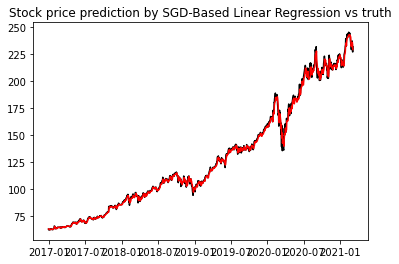

In [73]:
import matplotlib.pyplot as plt
dates = test_set.index.values
plot_truth = plt.plot(dates, y_test, 'black')
plot_lr = plt.plot(dates, lr_predictions, 'red')
plt.title('Stock price prediction by SGD-Based Linear Regression vs truth')
plt.show()

# Performence evaluation
sensitivity analysis


In [74]:
import numpy as np
mse_lr=[]
mae_lr=[]
r2_lr=[]
# Collect MSE, MAE and R-square across 100 random seeds
for i in np.arange(0,99):
    lr = SGDRegressor(penalty="l2", max_iter=1000, eta0=0.01, alpha=0, random_state=i)
    lr.fit(X_scaled_train, y_train)
    lr_predictions = lr.predict(X_scaled_test)
    mse_lr.append(mean_squared_error(y_test, lr_predictions))
    mae_lr.append(mean_absolute_error(y_test, lr_predictions))
    r2_lr.append(r2_score(y_test, lr_predictions))
# Calculate the means
print (np.mean(np.array(mse_lr)))
print (np.mean(np.array(mae_lr)))
print (np.mean(np.array(r2_lr)))


6.34940503831332
1.601744637843219
0.9975514778353819


Benchmark

In [75]:
# Create an array with the same shape as the test same, filled with the means of the training set.
benchmark = np.full(y_test.shape, np.mean(y_train))
print("MSE: {0:.3f}".format(mean_squared_error(y_test, benchmark)))
print("MAE: {0:.3f}".format(mean_absolute_error(y_test, benchmark)))
print("R^2: {0:.3f}".format(r2_score(y_test, benchmark)))

MSE: 13638.076
MAE: 105.095
R^2: -4.259


SGD-LR

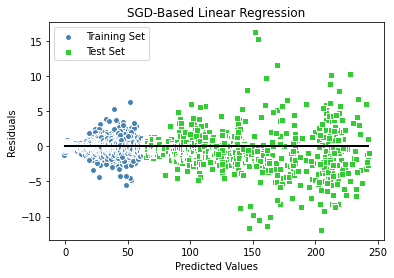

In [76]:
y_train_pred = lr_best.predict(X_scaled_train)
y_test_pred = lr_best.predict(X_scaled_test)
plt.scatter(y_train_pred, y_train_pred-y_train, c="steelblue", marker="o", edgecolor="white", label="Training Set")
plt.scatter(y_test_pred, y_test_pred-y_test, c="limegreen", marker="s", edgecolor="white", label="Test Set")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=min(np.concatenate((y_train_pred, y_test_pred), axis=0)), xmax=max(np.concatenate((y_train_pred, y_test_pred), axis=0)), color="black", lw=2)
plt.title("SGD-Based Linear Regression")
plt.show()